# Initialising

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from IPython import get_ipython
from IPython.display import display


In [94]:
def load_and_preprocess_data():
    # Load datasets
    constructor_results = pd.read_csv('constructor_results.csv')
    constructor_standings = pd.read_csv('constructor_standings.csv')
    qualifying = pd.read_csv('qualifying.csv')
    constructors = pd.read_csv('constructors.csv')

    # Convert 'q1', 'q2', 'q3' columns to numeric, coercing errors to NaN
    for col in ['q1', 'q2', 'q3']:
        qualifying[col] = pd.to_numeric(qualifying[col], errors='coerce')

    # Merge datasets
    merged_data = pd.merge(constructor_results, constructors[['constructorId', 'nationality']], on='constructorId')
    merged_data = pd.merge(merged_data, constructor_standings[['constructorId', 'raceId', 'wins']], on=['constructorId', 'raceId'])

    # Create features
    features = merged_data[['constructorId', 'nationality']]

    # Average points per constructor
    features['avg_points'] = merged_data.groupby('constructorId')['points'].transform('mean')

    # Points consistency (standard deviation)
    features['points_std'] = merged_data.groupby('constructorId')['points'].transform('std')

    # Win rate
    features['win_rate'] = merged_data.groupby('constructorId')['wins'].transform('mean')

    # Nationality encoding
    le = LabelEncoder()
    features['nationality'] = le.fit_transform(features['nationality'])

    # Target variable
    y = merged_data['points']

    # Impute missing values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

    return features, y


# EDA

Qualifying Analysis

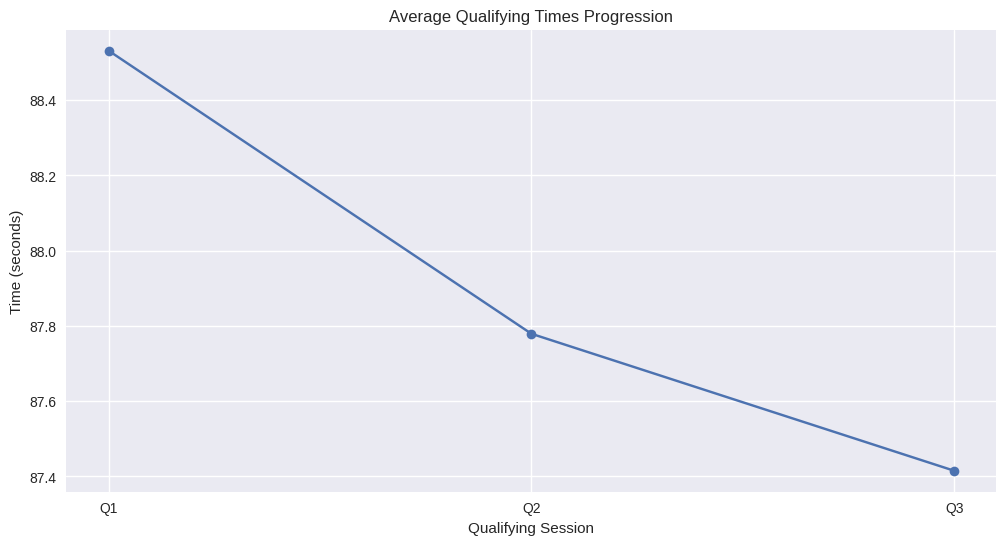

In [89]:
plt.figure(figsize=(12, 6))
qualifying_means = qualifying[['q1', 'q2', 'q3']].mean()
plt.plot(['Q1', 'Q2', 'Q3'], qualifying_means, marker='o')
plt.title('Average Qualifying Times Progression')
plt.ylabel('Time (seconds)')
plt.xlabel('Qualifying Session')
plt.grid(True)
plt.show()

Constructor Nationality Analysis

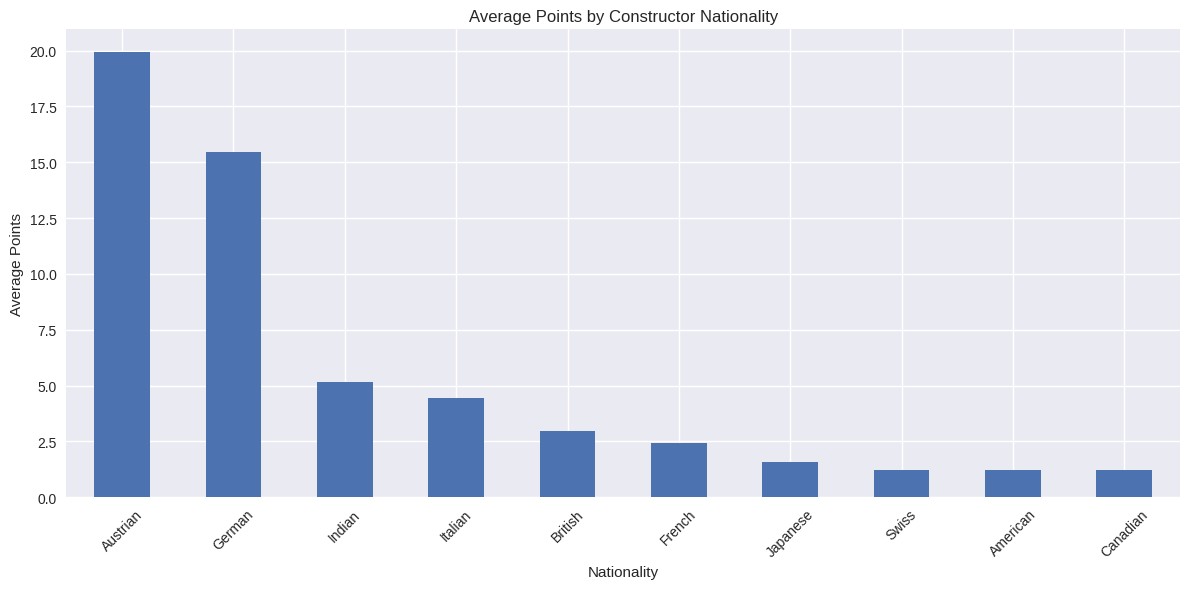

In [ ]:
plt.figure(figsize=(12, 6))
nationality_performance = merged_results.groupby('nationality')['points'].mean().sort_values(ascending=False)[:10]
nationality_performance.plot(kind='bar')
plt.title('Average Points by Constructor Nationality')
plt.xlabel('Nationality')
plt.ylabel('Average Points')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Points Progression Analysis

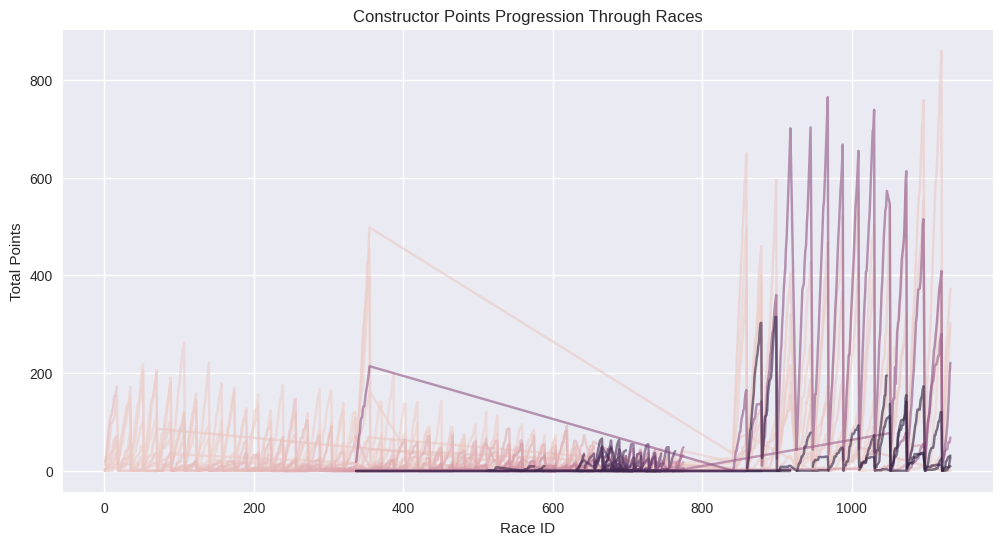

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=constructor_standings, x='raceId', y='points', hue='constructorId', legend=False, alpha=0.6)
plt.title('Constructor Points Progression Through Races')
plt.xlabel('Race ID')
plt.ylabel('Total Points')
plt.show()

Additional Analysis: Performance Metrics

In [ ]:
def calculate_performance_metrics(data):
    metrics = {
        'avg_points': data.groupby('constructorId')['points'].mean(),
        'total_points': data.groupby('constructorId')['points'].sum(),
        'races_participated': data.groupby('constructorId').size(),
        'points_std': data.groupby('constructorId')['points'].std()
    }
    return pd.DataFrame(metrics)

correlation matrix

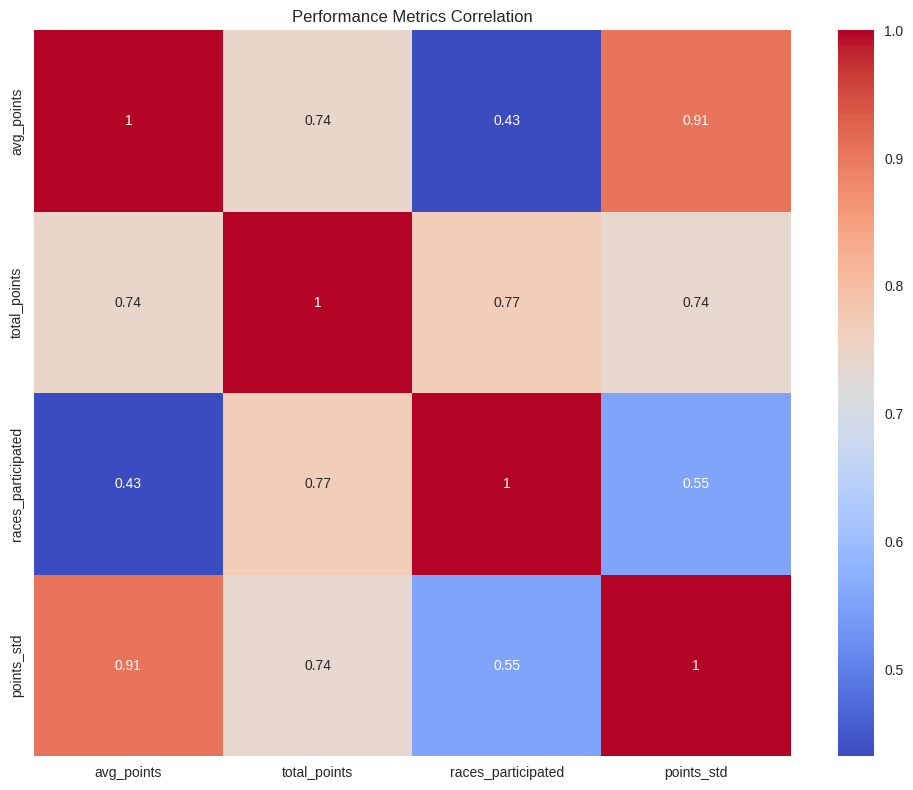

In [ ]:
performance_metrics = calculate_performance_metrics(merged_results)
plt.figure(figsize=(10, 8))
sns.heatmap(performance_metrics.corr(), annot=True, cmap='coolwarm')
plt.title('Performance Metrics Correlation')
plt.tight_layout()
plt.show()

# Model

In [95]:
def train_model(X, y):
    # Split data with stratification for better distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    # Scale features with robust scaling for handling outliers
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    # Initialize GradientBoostingRegressor with early stopping parameters
    model = GradientBoostingRegressor(
        random_state=42,
        validation_fraction=0.1,  # Use 10% of training data for validation
        n_iter_no_change=5,  # Stop if validation score doesn't improve for 5 iterations
        tol=1e-4 # tolerance for validation score.
    )

    # Perform grid search
    grid_search = GridSearchCV(
       model, param_grid,
       cv=5, scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Train the best model (early stopping is handled during initialization)
    best_model.fit(X_train_scaled, y_train)

    # Predictions and metrics
    y_pred = best_model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return best_model, scaler, rmse, r2, X_test_scaled, y_test

def main():
    # Load and preprocess data
    features, y = load_and_preprocess_data()

    # Train model
    model, scaler, rmse, r2, X_test_scaled, y_test = train_model(features, y)

    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")

    return model, scaler, features, y, X_test_scaled, y_test

if __name__ == "__main__":
    model, scaler, features, y, X_test_scaled, y_test = main()

<ipython-input-94-3c923d069dcf>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['avg_points'] = merged_data.groupby('constructorId')['points'].transform('mean')
<ipython-input-94-3c923d069dcf>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['points_std'] = merged_data.groupby('constructorId')['points'].transform('std')
<ipython-input-94-3c923d069dcf>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Root Mean Squared Error: 5.63
R-squared: 0.46


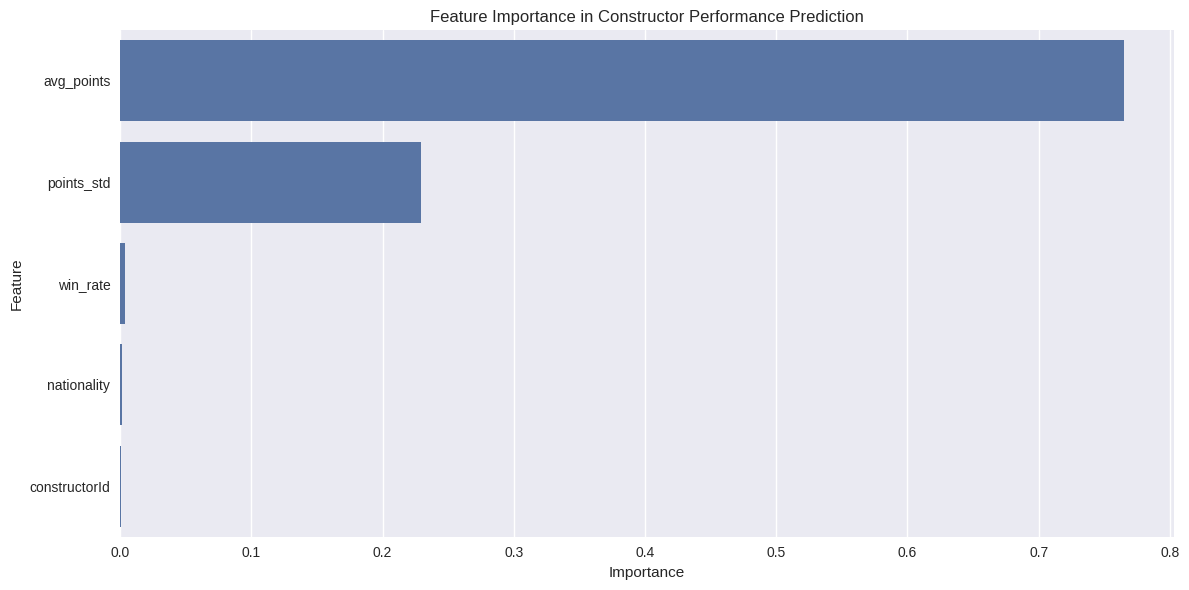

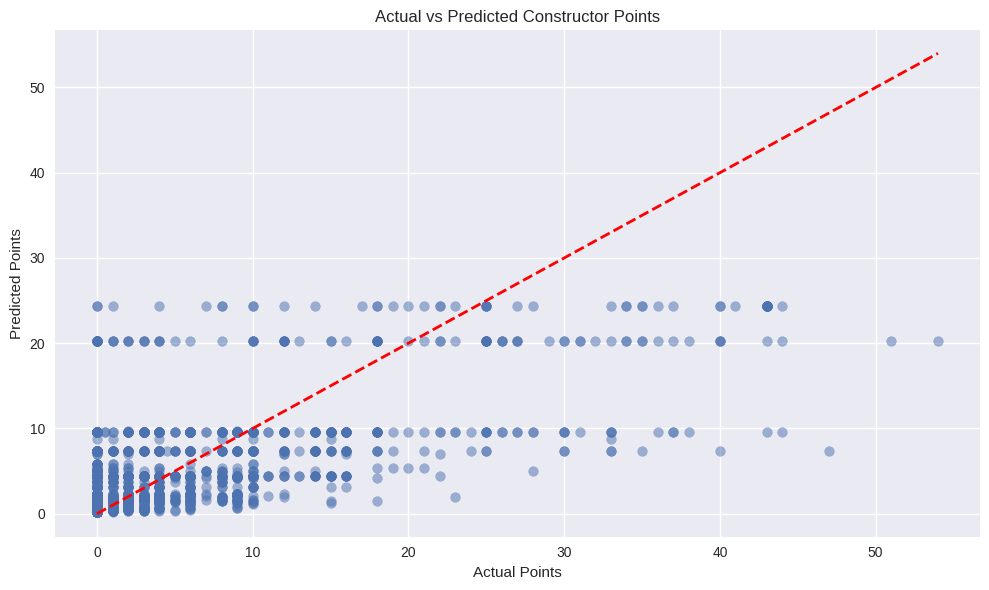

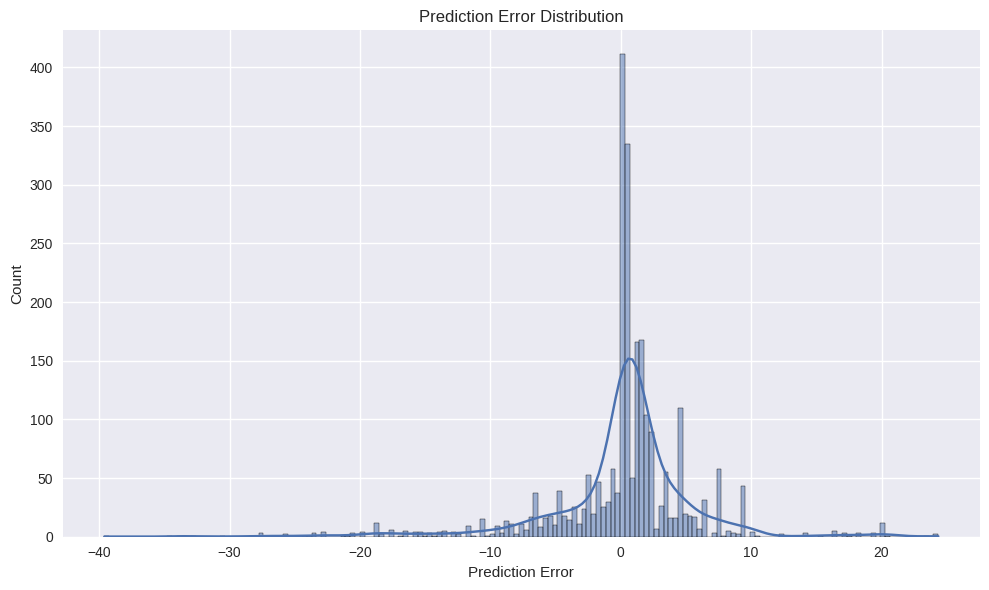

In [96]:
# Plot feature importance
plt.figure(figsize=(12, 6))
feature_names = features.columns  # Assuming 'features' is the DataFrame from load_and_preprocess_data
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_  # Use 'model' from your 'main' function
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Constructor Performance Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
y_pred = model.predict(X_test_scaled)  # Use 'model' from your 'main' function
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Constructor Points')
plt.tight_layout()
plt.show()
# Plot prediction error distribution
plt.figure(figsize=(10, 6))
error = y_pred - y_test
sns.histplot(error, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.tight_layout()
plt.show()